# Generate splits for our Wikidata dataset

We want to obtain splits of 80% for training, 10% for validation and 10% for testing. It is important to divide with respect to the Q-values, not the individual samples.

In [1]:
import os
import re
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd

## Dataset Loading

In [2]:
df = pd.read_csv("../data/wikidata_triplet2text_alpha_generated.csv")
df.head()

,q_id,q_name,p_id,p_name,p_value,p_value_type,positive_negative,text
0,Q23,George Washington,P509,cause_of_death,epiglottitis,wikibase-item,positive,"George Washington, the first President of the ..."
1,Q23,George Washington,P20,place_of_death,Mount Vernon,wikibase-item,positive,"George Washington, the first President of the ..."
2,Q23,George Washington,P26,spouse,Martha Washington,wikibase-item,positive,"George Washington, the esteemed first Presiden..."
3,Q23,George Washington,P22,father,Augustine Washington,wikibase-item,positive,"George Washington, the first President of the ..."
4,Q23,George Washington,P25,mother,Mary Ball Washington,wikibase-item,positive,"George Washington, the first President of the ..."


## Slot mapping

In [3]:
wikidata2our_slots = {
    "charge": "per:charges",
    "relative": "per:other_family",
    "sibling": "per:siblings",
    "father": "per:parents",
    "mother": "per:parents",
    "child": "per:children",
    "spouse": "per:spouse",
    "religion_or_worldview": "per:religion",
    "employer": "per:employee_or_member_of",
    "noble_title": "per:title",
    "educated_at": "per:schools_attended",
    "residence": "per:place_of_residence",
    "cause_of_death": "per:cause_of_death",
    "place_of_death": "per:place_of_death",
    "date_of_death": "per:date_of_death",
    "place_of_birth": "per:place_of_birth",
    "date_of_birth": "per:date_of_birth",
    "alternative_name": "per:alternative_names",
    "official_website": "org:website",
    "owned_by": "org:shareholders",
    "headquarters_location": "org:headquarters_location",
    "dissolved_abolished_or_demolished": "org:date_dissolved",
    "inception": "org:date_founded",
    "founder": "org:founded_by",
    "parent_organization": "org:parent_organization",
    "subsidiary": "org:subsidiaries",
    "member_of": "org:member_of",
    "number_of_employees": "org:number_of_employees_members",
    "no_relation": "no_relation",
}

In [4]:
# We need to map the p_name to our mapping
df["p_name"] = df["p_name"].map(wikidata2our_slots)

# Now, anything outside of our slots, will be changed to "no_relation"
for index, row in df.iterrows():
    if row["p_name"] not in wikidata2our_slots.values():
        df.at[index, "p_name"] = "no_relation"

In [5]:
# Print the unique p_names
print(df["p_name"].unique())

['per:cause_of_death' 'per:place_of_death' 'per:spouse' 'per:parents'
 'no_relation' 'per:date_of_birth' 'per:date_of_death' 'org:member_of'
 'per:religion' 'per:siblings' 'per:place_of_residence' 'per:other_family'
 'per:place_of_birth' 'per:children' 'per:employee_or_member_of'
 'org:website' 'per:schools_attended' 'per:title'
 'org:headquarters_location' 'org:founded_by' 'org:shareholders'
 'org:date_founded' 'per:charges' 'org:subsidiaries'
 'org:number_of_employees_members' 'org:parent_organization'
 'org:date_dissolved' 'per:alternative_names']


## Formatting

### Normalizing date format for full dates

In [6]:
# If we find something that matches the regex of a date in any row of the dataset, we will store only the first group (the date itself)
regex_pattern = r"(\w+ \d{1,2}, \d{4}).*UTC"
for index, row in df.iterrows():
    match_text = re.search(regex_pattern, row["text"])
    match_p_value = re.search(regex_pattern, row["p_value"])
    if match_text:
        value_to_store = match_text.group(1)
        # If there is 01, 02, 03, etc. in the date, we will remove the leading 0
        date_obj = datetime.strptime(value_to_store, "%B %d, %Y")
        formatted_date = date_obj.strftime("%B %-d, %Y")

        # Replace the original text with the formatted date
        df.at[index, "text"] = formatted_date

        # Replace the matched value with the formatted date
        df.at[index, "text"] = re.sub(regex_pattern, formatted_date, row["text"])

        if row["text"] == "September 07, 1881":
            print(row["text"])

    if match_p_value:
        value_to_store = match_p_value.group(1)
        # If there is 01, 02, 03, etc. in the date, we will remove the leading 0
        date_obj = datetime.strptime(value_to_store, "%B %d, %Y")
        formatted_date = date_obj.strftime("%B %-d, %Y")
        # Store the first group in the dataset
        df.at[index, "p_value"] = formatted_date

### Normalizing date format for partial dates

In [7]:
# If we have a date like July 09, 1914, remove the leading 0
regex_pattern = r"(\w+ \d{2}, \d{4})"

for index, row in df.iterrows():
    match_text = re.search(regex_pattern, row["text"])
    match_p_value = re.search(regex_pattern, row["p_value"])
    if match_text:
        value_to_store = match_text.group(1)
        # If there is 01, 02, 03, etc. in the date, we will remove the leading 0
        try:
            date_obj = datetime.strptime(value_to_store, "%B %d, %Y")
            formatted_date = date_obj.strftime("%B %-d, %Y")
        except ValueError:
            continue

        # Replace the original text with the formatted date
        df.at[index, "text"] = formatted_date

        # Replace the matched value with the formatted date
        df.at[index, "text"] = re.sub(regex_pattern, formatted_date, row["text"])

    if match_p_value:
        value_to_store = match_p_value.group(1)
        # If there is 01, 02, 03, etc. in the date, we will remove the leading 0
        date_obj = datetime.strptime(value_to_store, "%B %d, %Y")
        formatted_date = date_obj.strftime("%B %-d, %Y")
        # Store the first group in the dataset
        df.at[index, "p_value"] = formatted_date

### Normalize website strings

In [8]:
# If we find something that matches the regex of a website, we remove the trailing slash
regex_pattern = r"(https?:\/\/(www\.)?[\w\.-]+\.\w+)"
for index, row in df.iterrows():
    # Find the first group that matches the regex pattern
    match_text = re.search(regex_pattern, row["text"])
    match_p_value = re.search(regex_pattern, row["p_value"])
    if match_text:
        # Store the first group in the dataset
        df.at[index, "text"] = match_text.group(1)
    if match_p_value:
        # Store the first group in the dataset
        df.at[index, "p_value"] = match_p_value.group(1)

## Adding [E1] and [E2] markers

In [9]:
counter = 0
str_fails = ""
str_hits = ""
for index, row in df.iterrows():
    transformed_text = row["text"]
    matched_E1_start = False
    matched_E1_end = False
    matched_E2_start = False
    matched_E2_end = False

    # Find the start position of row["q_name"] in row["text"] and place "[E1]" before it in the transformed_text variable
    transformed_text = transformed_text.replace(row["q_name"], "[E1] " + row["q_name"])

    # Find the end position of row["q_name"] in row["text"] and place "[/E1]" after it
    transformed_text = transformed_text.replace(row["q_name"], row["q_name"] + " [/E1]")

    # Find the start position of row["p_value"] in row["text"] and place "[E2]" before it
    transformed_text = transformed_text.replace(
        row["p_value"], "[E2] " + row["p_value"]
    )

    # Find the end position of row["p_value"] in row["text"] and place "[/E2]" after it
    transformed_text = transformed_text.replace(
        row["p_value"], row["p_value"] + " [/E2]"
    )

    if "[E1]" in transformed_text:
        matched_E1_start = True

    if "[/E1]" in transformed_text:
        matched_E1_end = True

    if "[E2]" in transformed_text:
        matched_E2_start = True

    if "[/E2]" in transformed_text:
        matched_E2_end = True

    if (
        matched_E1_start is False
        or matched_E1_end is False
        or matched_E2_start is False
        or matched_E2_end is False
    ):
        str_fails += "----------------\n"
        str_fails += row["q_name"] + "\n"
        str_fails += row["p_value"] + "\n"
        str_fails += transformed_text + "\n"
        counter += 1

        # Drop the row if we don't have a match
        df.drop(index, inplace=True)

        continue

    else:
        str_hits += "----------------\n"
        str_hits += row["q_name"] + "\n"
        str_hits += row["p_value"] + "\n"
        str_hits += transformed_text + "\n"

    # Add the transformed_text to the dataset
    df.at[index, "transformed_text"] = transformed_text

# Check if the file exists and remove it
if os.path.exists("fails.txt"):
    os.remove("fails.txt")

if os.path.exists("hits.txt"):
    os.remove("hits.txt")

# Print str_fails in a .txt file
with open("fails.txt", "w") as text_file:
    text_file.write(str_fails)

# Print str_hits in a .txt file
with open("hits.txt", "w") as text_file:
    text_file.write(str_hits)

print(f"Number of rows with no match: {counter}")

Number of rows with no match: 20627


## Balancing positive and negative samples

In [10]:
print(f"Length before balancing positive and negative samples: {len(df)}")
print(f"Number of positive samples: {len(df[df['positive_negative'] == 'positive'])}")
print(f"Number of negative samples: {len(df[df['positive_negative'] == 'negative'])}")

Length before balancing positive and negative samples: 107190
Number of positive samples: 66810
Number of negative samples: 40380


In [11]:
# We need to ensure that we have a split of positive and negative examples of 80/20
# Therefore, we will calculate the amount of positive examples and remove negative examples until we have 80/20
positive_examples = df[df["positive_negative"] == "positive"]
negative_examples = df[df["positive_negative"] == "negative"]

# Calculate the amount of negative examples we need to remove
amount_to_remove = int(len(positive_examples) * 20 / 80)
negative_examples = negative_examples.sample(frac=1, random_state=24).reset_index(
    drop=True
)
negative_examples = negative_examples[:amount_to_remove]

# Concatenate the positive and negative examples
df = pd.concat([positive_examples, negative_examples])

In [12]:
print(f"Length after balancing positive and negative samples: {len(df)}")
print(f"Number of positive samples: {len(df[df['positive_negative'] == 'positive'])}")
print(f"Number of negative samples: {len(df[df['positive_negative'] == 'negative'])}")

Length after balancing positive and negative samples: 83512
Number of positive samples: 66810
Number of negative samples: 16702


## Splitting

In [13]:
df.head()

,q_id,q_name,p_id,p_name,p_value,p_value_type,positive_negative,text,transformed_text
0,Q23,George Washington,P509,per:cause_of_death,epiglottitis,wikibase-item,positive,"George Washington, the first President of the ...","[E1] George Washington [/E1], the first Presid..."
1,Q23,George Washington,P20,per:place_of_death,Mount Vernon,wikibase-item,positive,"George Washington, the first President of the ...","[E1] George Washington [/E1], the first Presid..."
2,Q23,George Washington,P26,per:spouse,Martha Washington,wikibase-item,positive,"George Washington, the esteemed first Presiden...","[E1] George Washington [/E1], the esteemed fir..."
3,Q23,George Washington,P22,per:parents,Augustine Washington,wikibase-item,positive,"George Washington, the first President of the ...","[E1] George Washington [/E1], the first Presid..."
4,Q23,George Washington,P25,per:parents,Mary Ball Washington,wikibase-item,positive,"George Washington, the first President of the ...","[E1] George Washington [/E1], the first Presid..."


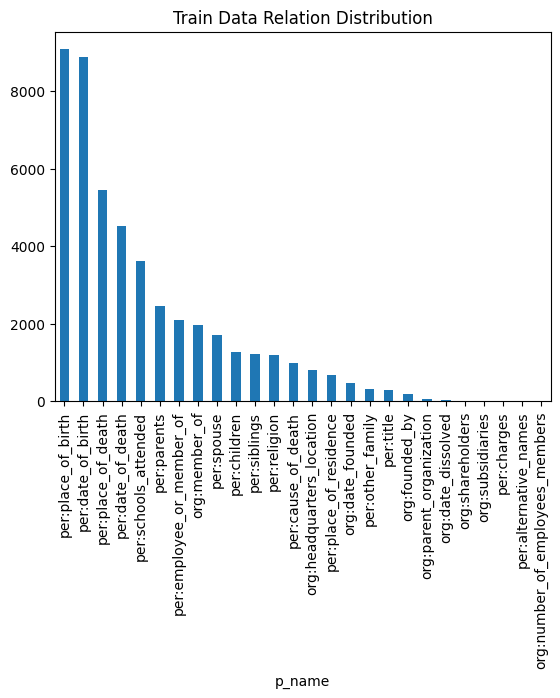

In [14]:
# Checkk the distribution of relations before splitting the dataset
def plot_relation_distribution(dataframe: pd.DataFrame, title: str):
    """
    Plot the distribution of relations in a column plot, excluding no_relation
    """
    relation_distribution = dataframe["p_name"].value_counts()
    relation_distribution = relation_distribution.drop("no_relation")
    relation_distribution.plot(kind="bar", title=title)
    plt.show()


plot_relation_distribution(df, "Train Data Relation Distribution")

In [15]:
# Now, we divide the data into training, validation and test sets, with respect to the column q_id
q_ids = df.q_id.unique()
q_ids = pd.Series(q_ids).sample(frac=1, random_state=24)
n = len(q_ids)
train_q_ids = q_ids[: int(0.8 * n)]
valid_q_ids = q_ids[int(0.8 * n) : int(0.9 * n)]
test_q_ids = q_ids[int(0.9 * n) :]

train_df = df[df.q_id.isin(train_q_ids)]
valid_df = df[df.q_id.isin(valid_q_ids)]
test_df = df[df.q_id.isin(test_q_ids)]

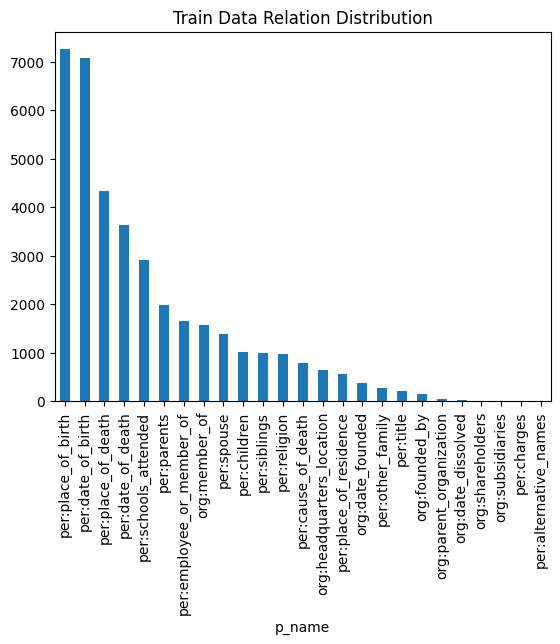

In [16]:
plot_relation_distribution(train_df, "Train Data Relation Distribution")

In [17]:
train_df.head()

,q_id,q_name,p_id,p_name,p_value,p_value_type,positive_negative,text,transformed_text
0,Q23,George Washington,P509,per:cause_of_death,epiglottitis,wikibase-item,positive,"George Washington, the first President of the ...","[E1] George Washington [/E1], the first Presid..."
1,Q23,George Washington,P20,per:place_of_death,Mount Vernon,wikibase-item,positive,"George Washington, the first President of the ...","[E1] George Washington [/E1], the first Presid..."
2,Q23,George Washington,P26,per:spouse,Martha Washington,wikibase-item,positive,"George Washington, the esteemed first Presiden...","[E1] George Washington [/E1], the esteemed fir..."
3,Q23,George Washington,P22,per:parents,Augustine Washington,wikibase-item,positive,"George Washington, the first President of the ...","[E1] George Washington [/E1], the first Presid..."
4,Q23,George Washington,P25,per:parents,Mary Ball Washington,wikibase-item,positive,"George Washington, the first President of the ...","[E1] George Washington [/E1], the first Presid..."


In [18]:
print(f"Train: {len(train_df)}")
print(f"Valid: {len(valid_df)}")
print(f"Test: {len(test_df)}")

Train: 66929
Valid: 8370
Test: 8213


## Final formatting

In [19]:
# Change the column name of q_name to subject
train_df = train_df.rename(columns={"q_name": "subject"})
valid_df = valid_df.rename(columns={"q_name": "subject"})
test_df = test_df.rename(columns={"q_name": "subject"})

# Change the column name of p_name to relation
train_df = train_df.rename(columns={"p_name": "relation"})
valid_df = valid_df.rename(columns={"p_name": "relation"})
test_df = test_df.rename(columns={"p_name": "relation"})

# Change the column name of p_value to object
train_df = train_df.rename(columns={"p_value": "object"})
valid_df = valid_df.rename(columns={"p_value": "object"})
test_df = test_df.rename(columns={"p_value": "object"})

## Saving datasets into csv

In [20]:
train_df.to_csv("../data/wikidata_triplet2text_alpha_generated_train.csv", index=False)
valid_df.to_csv("../data/wikidata_triplet2text_alpha_generated_valid.csv", index=False)
test_df.to_csv("../data/wikidata_triplet2text_alpha_generated_test.csv", index=False)